# Manufatura

 * 50 máquinas trabalham sem parar 8 horas por dia 5 dias por semana
 * Cada máquina quebra após certo tempo aleatório, entre 132 e 182 (uniforme) horas de uso
 * Máquinas quebradas podem ser imediatamente substituídas por máquinas reservas (se existirem)
 * Máquinas quebradas são imediatamente enviadas para o concerto.
 * O concerto dura um tempo aleatório, entre 4 e 10 (uniforme) horas
 * Assim que o concerto termina, a máquina concertada:
    * vira uma máquina reserva, caso existam 50 máquinas trabalhando
    * entra para a produção, caso existam menos de 50 máquinas trabalhando
 * Sempre que uma das 50 posições não está sendo ocupada existe uma pena de $20/hora/máquina
 
### Opções

 * Contratar $R$ técnicos para concertar máquinas quebradas por \$3.75 por hora cada
 * Alugar $S$ máquinas reserva por \$30 por dia cada
 
### Objetivo

Minimizar o custo de produção

In [0]:
!pip3 install simpy

In [0]:
import matplotlib.pylab as plt
import numpy as np
import simpy

### Configurações

In [0]:
R = 7
S = 7

In [0]:
def generate_repair_time():
    return np.random.uniform(4, 10)
  
def generate_time_to_failure():
    return np.random.uniform(132, 182)

### Fábrica

In [0]:
def factory_run(env, repairers, spares):
    global cost
    cost = 0

    for i in range(50):
        env.process(operate_machine(env, repairers, spares))
    
    while True:
        cost += 8 * 3.25 * R + 30 * S
        yield env.timeout(8)

### Máquinas

In [0]:
def operate_machine(env, repairers, spares):
    global cost
    
    while True:
        yield env.timeout(generate_time_to_failure())
        t_broken = env.now
        print('Maquina quebrou {:.2f}'.format(t_broken))
        env.process(repair_machine(env, repairers, spares))
        yield spares.get(1)
        t_replaced = env.now
        print('Maquina substituida {:.2f}'.format(t_replaced))
        cost += 20 * (t_replaced - t_broken)

### Concerto

In [0]:
def repair_machine(env, repairers, spares):
    with repairers.request() as request:
        yield request
        yield env.timeout(generate_repair_time())
        yield spares.put(1)
    print('Maquina concertada {:.2f}'.format(env.now))
    

### Observador

In [0]:
obs_time = []
obs_cost = []
obs_spares = []
def observe(env, spares):
    while True:
        obs_time.append(env.now)
        obs_cost.append(cost)
        obs_spares.append(spares.level)
        yield env.timeout(1)

### Simulação

In [0]:
env = simpy.Environment()
repairers = simpy.Resource(env, capacity=R)
spares = simpy.Container(env, init=S, capacity=S)
env.process(factory_run(env, repairers, spares))
env.process(observe(env, spares))
env.run(until=8*5*52)

Maquina quebrou 132.96
Maquina substituida 132.96
Maquina quebrou 134.17
Maquina substituida 134.17
Maquina quebrou 134.41
Maquina substituida 134.41
Maquina quebrou 134.83
Maquina substituida 134.83
Maquina quebrou 135.31
Maquina substituida 135.31
Maquina quebrou 136.49
Maquina substituida 136.49
Maquina quebrou 137.22
Maquina substituida 137.22
Maquina concertada 139.36
Maquina quebrou 140.00
Maquina substituida 140.00
Maquina quebrou 141.01
Maquina concertada 141.37
Maquina substituida 141.37
Maquina concertada 141.41
Maquina concertada 141.46
Maquina concertada 141.57
Maquina quebrou 142.12
Maquina substituida 142.12
Maquina quebrou 142.24
Maquina substituida 142.24
Maquina quebrou 142.55
Maquina substituida 142.55
Maquina quebrou 143.09
Maquina quebrou 143.49
Maquina quebrou 143.52
Maquina concertada 144.53
Maquina substituida 144.53
Maquina concertada 144.90
Maquina substituida 144.90
Maquina quebrou 144.97
Maquina quebrou 145.21
Maquina quebrou 145.65
Maquina concertada 145.69


### Resultados

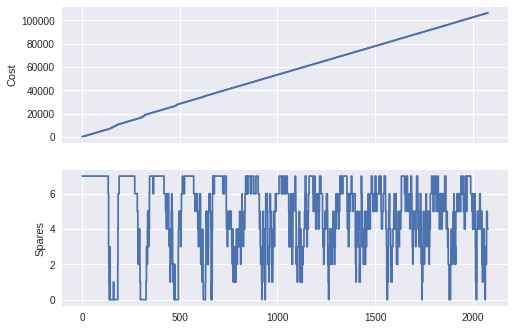

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.step(obs_time, obs_cost, where='post')
ax1.set_ylabel('Cost')
ax2.step(obs_time, obs_spares, where='post')
ax2.set_ylabel('Spares')
plt.show()

In [0]:
print(f'Final: ${obs_cost[-1]}')

Final: $106134.4080531832
